# Support vector machines

In [1]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, f_regression

from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

## Data pre-processing

In [2]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv ('test_features.csv')

### Sorting labels

In [4]:
df_train_labels = df_train_labels.sort_values(by = 'pid')
df_train_features = df_train_features.sort_values(by = 'pid')

 ### Histogram of the output labels 

We should check for class imbalance.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129110b50>,
      dtype=object)

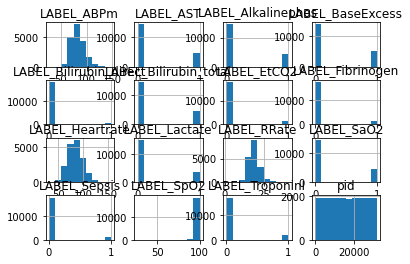

In [3]:
df_train_labels.hist()

# with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Train Data pre-processing

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

In [ ]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

In [ ]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

### Train data pre-processing

In [5]:
df_train_agg_features = df_train_features.groupby('pid').agg([np.min, np.max, np.mean])
df_train_agg_features = df_train_agg_features.iloc[:,5:]
# Removing ETCo2 mean and max since it has so many NA
df_train_agg_features = df_train_agg_features.drop(df_train_agg_features.columns[[2,3]],  axis = 1)
print(df_train_agg_features.columns)
df_train_agg_features.columns
print(int(df_train_agg_features.shape[1]))
print(int(df_train_agg_features.shape[1]/3))

# how much missing data? 
print("number of missing values:")
print(df_train_agg_features.isnull().sum(axis=0))

na_percent_max = int(0.8 * df_train_agg_features.shape[0])
tmp = pd.DataFrame(df_train_agg_features)
for i in range(1, (int(df_train_agg_features.shape[1]/3))):
    na_count = df_train_agg_features.iloc[:,i].isna().sum()
    print(df_train_agg_features.columns[i])
    print(na_count)
    
    if(na_count > na_percent_max):
        print("should be removed")


MultiIndex([(            'Age', 'mean'),
            (          'EtCO2', 'amin'),
            (            'PTT', 'amin'),
            (            'PTT', 'amax'),
            (            'PTT', 'mean'),
            (            'BUN', 'amin'),
            (            'BUN', 'amax'),
            (            'BUN', 'mean'),
            (        'Lactate', 'amin'),
            (        'Lactate', 'amax'),
            ...
            ('Bilirubin_total', 'mean'),
            (      'TroponinI', 'amin'),
            (      'TroponinI', 'amax'),
            (      'TroponinI', 'mean'),
            (           'ABPs', 'amin'),
            (           'ABPs', 'amax'),
            (           'ABPs', 'mean'),
            (             'pH', 'amin'),
            (             'pH', 'amax'),
            (             'pH', 'mean')],
           length=101)
101
33
number of missing values:
Age    mean        0
EtCO2  amin    17673
PTT    amin    11179
       amax    11179
       mean    11179
  

In [6]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors = 10)
#imputer = IterativeImputer(random_state=0, verbose = 2, max_iter = 30)
df_train_agg_imputed_features = imputer.fit_transform(df_train_agg_features)
#print(df_train_agg_imputed_features)

In [7]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [106]:
# REARRANGE THE LABELS, TO MATCH THE REARRANGED FEATURES
df_train_labels_sorted = df_train_labels.sort_values(by = 'pid')
print(df_train_labels_sorted[['pid']])
print(df_train_labels[['pid']])
print(df_train_agg_features)

         pid
0          1
6622       2
15008      4
16335      6
17676      8
...      ...
14402  31653
14403  31654
14404  31656
14405  31657
14406  31658

[18995 rows x 1 columns]
         pid
0          1
1         10
2        100
3       1000
4      10000
...      ...
18990   9993
18991   9995
18992   9996
18993   9998
18994   9999

[18995 rows x 1 columns]
        Age   PTT               BUN             Lactate            ...  \
       mean  amin  amax  mean  amin  amax  mean    amin amax mean  ...   
pid                                                                ...   
1      34.0   NaN   NaN   NaN  12.0  12.0  12.0     NaN  NaN  NaN  ...   
2      86.0  31.8  31.8  31.8  32.0  32.0  32.0     NaN  NaN  NaN  ...   
4      66.0  34.6  34.6  34.6   8.0   8.0   8.0     NaN  NaN  NaN  ...   
6      66.0  53.8  53.8  53.8  32.0  32.0  32.0     1.8  1.8  1.8  ...   
8      42.0   NaN   NaN   NaN  18.0  18.0  18.0     NaN  NaN  NaN  ...   
...     ...   ...   ...   ...   ...   ...   

In [ ]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [ ]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

### PCA plot 

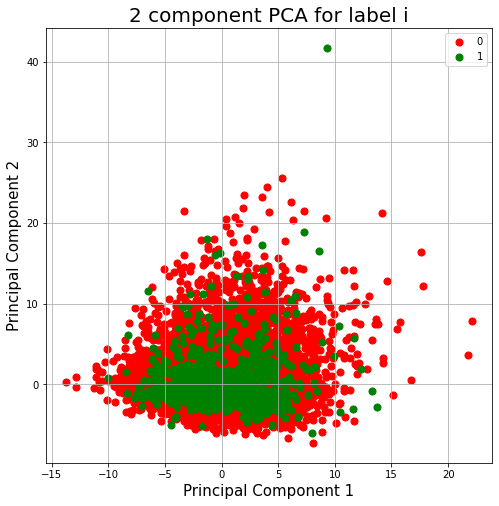

In [14]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_train_labels[[df_train_labels.columns[11]]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for label i', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[df_train_labels.columns[11]] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Test Data pre-processing

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_test_features.agg([min, max]))

# how much missing data? 
print("number of missing values:")
print(df_test_features.isnull().sum(axis=0))

In [9]:
# # aggregate data for each pid
# df_test_aggregate_features = df_test_features.groupby('pid').agg('median')

df_test_agg_features = df_test_features.groupby('pid').agg([np.min, np.max, np.mean])

df_test_agg_features = df_test_agg_features.iloc[:,5:]
# Removing ETCo2 mean and max since it has so many NA
df_test_agg_features = df_test_agg_features.drop(df_test_agg_features.columns[[2,3]],  axis = 1)

In [10]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?

imputer = KNNImputer(n_neighbors= 10)
#imputer = IterativeImputer(random_state=0, verbose = 1)
df_test_agg_imputed_features = imputer.fit_transform(df_test_agg_features)

In [11]:
# scale test data
min_max_scaler = preprocessing.StandardScaler()
data_test_scaled = min_max_scaler.fit_transform(df_test_agg_imputed_features)

In [19]:
# pd.DataFrame(data_train_scaled).to_csv("./Results/4stats_iterarive_dat_train_scaled.csv")
# pd.DataFrame(data_test_scaled).to_csv("./Results/4stats_iterative_dat_test_scaled.csv")

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [ ]:
# first for the labels that have an output [0,1]
test_pids = list(set(df_test_features.pid))
columns_1 = [test_pids]

for i in range(1, 12):
   
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=30)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print("For feature ", df_train_labels.columns[i])
    print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    
    #clf = BaggingClassifier(SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10))
    clf_w = SVC(kernel = 'rbf', gamma = 'auto', class_weight = 'balanced', verbose = 2)
    
    parameters = {'C':(0.1, 1,10, 30)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                        refit = True, scoring = 'roc_auc', verbose = 2,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

For feature  LABEL_BaseExcess
MultiIndex([(       'PTT', 'amin'),
            (       'PTT', 'amax'),
            (   'Lactate', 'amin'),
            (   'Lactate', 'amax'),
            (   'Lactate', 'mean'),
            (      'HCO3', 'amin'),
            (      'HCO3', 'amax'),
            (      'HCO3', 'mean'),
            ('BaseExcess', 'amin'),
            ('BaseExcess', 'amax'),
            ('BaseExcess', 'mean'),
            ('Creatinine', 'amin'),
            ('Creatinine', 'amax'),
            ('Creatinine', 'mean'),
            (     'PaCO2', 'amin'),
            (     'PaCO2', 'amax'),
            (     'PaCO2', 'mean'),
            (      'FiO2', 'amin'),
            (      'FiO2', 'amax'),
            (      'FiO2', 'mean'),
            (      'SaO2', 'amin'),
            (      'ABPm', 'mean'),
            (      'ABPd', 'mean'),
            (   'Calcium', 'amin'),
            (  'Chloride', 'amin'),
            (  'Chloride', 'amax'),
            (  'Chloride', 'mean')

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  1.9min finished


[LibSVM]{'mean_fit_time': array([17.28407998, 16.25491848, 19.33904142, 29.83871431]), 'std_fit_time': array([0.12611069, 0.32322955, 0.5137879 , 4.87276751]), 'mean_score_time': array([1.98440313, 1.87405767, 1.91323318, 1.29454465]), 'std_score_time': array([0.01350047, 0.03070752, 0.19604364, 0.26151272]), 'param_C': masked_array(data=[0.1, 1, 10, 30],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 30}], 'split0_test_score': array([0.84106146, 0.85819628, 0.85749635, 0.84799829]), 'split1_test_score': array([0.82781363, 0.84953721, 0.84648548, 0.83627092]), 'split2_test_score': array([0.83844367, 0.86206007, 0.85498514, 0.84110427]), 'split3_test_score': array([0.83565564, 0.8510509 , 0.84366815, 0.83229397]), 'split4_test_score': array([0.83971696, 0.85600391, 0.84667434, 0.83311718]), 'mean_test_score': array([0.83653827, 0.85536967, 0.84986189, 0.83815693]), 'std_test_score': arra

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


In [80]:
# labels that have a real value
columns_2 = []
# from sklearn.kernel_ridge import KernelRidge

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param = 50)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    clf_w = SVR(kernel = 'rbf')
# #     clf_w = NuSVR(nu=0.5, kernel = 'linear')
    parameters = {'C':(0.1, 1,10)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    

MultiIndex([(             'BUN', 'amin'),
            (         'Lactate', 'amin'),
            (            'Temp', 'amax'),
            (             'Hgb', 'mean'),
            (      'BaseExcess', 'amax'),
            (           'RRate', 'amin'),
            (           'RRate', 'amax'),
            (           'RRate', 'mean'),
            (      'Fibrinogen', 'amax'),
            (       'Phosphate', 'amax'),
            (             'WBC', 'amin'),
            (             'WBC', 'amax'),
            (             'WBC', 'mean'),
            (      'Creatinine', 'amax'),
            (      'Creatinine', 'mean'),
            (           'PaCO2', 'amin'),
            (           'PaCO2', 'amax'),
            (             'AST', 'amax'),
            (             'AST', 'mean'),
            (            'FiO2', 'amin'),
            (            'FiO2', 'amax'),
            (            'FiO2', 'mean'),
            (       'Platelets', 'mean'),
            (            'SaO2', '

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:  1.2min remaining:   18.7s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  1.6min finished


{'mean_fit_time': array([21.54526253, 23.55829906, 37.47510796]), 'std_fit_time': array([0.047214  , 0.7688025 , 4.67507681]), 'mean_score_time': array([4.8946321 , 4.70793958, 3.68959002]), 'std_score_time': array([0.01433916, 0.07766593, 0.36837234]), 'param_C': masked_array(data=[0.1, 1, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([-0.00778206, -0.01931859, -0.08694232]), 'split1_test_score': array([-0.01561896, -0.02039647, -0.06547105]), 'split2_test_score': array([-0.00994633, -0.019823  , -0.0765745 ]), 'split3_test_score': array([-0.01664153, -0.02941238, -0.07945536]), 'split4_test_score': array([-0.01361531, -0.02084413, -0.07759094]), 'mean_test_score': array([-0.01272084, -0.02195891, -0.07720683]), 'std_test_score': array([0.00336632, 0.00376222, 0.00690089]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
{'C': 0.1}
-0.012720837287059306
R2 for fe

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:   55.9s remaining:   14.0s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  1.2min finished


{'mean_fit_time': array([22.57191396, 22.46946783, 20.11467276]), 'std_fit_time': array([0.02657337, 0.0906857 , 3.40488934]), 'mean_score_time': array([4.53720922, 4.50196881, 3.66470423]), 'std_score_time': array([0.02057075, 0.02167888, 0.55807224]), 'param_C': masked_array(data=[0.1, 1, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([-0.01296042, -0.02007131, -0.05247492]), 'split1_test_score': array([-0.00960062, -0.01340969, -0.04900209]), 'split2_test_score': array([-0.02282063, -0.02707379, -0.05599584]), 'split3_test_score': array([-0.0242738 , -0.03102903, -0.06613368]), 'split4_test_score': array([-0.00713664, -0.01241738, -0.04372655]), 'mean_test_score': array([-0.01535842, -0.02080024, -0.05346662]), 'std_test_score': array([0.00695225, 0.00734043, 0.00751845]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
{'C': 0.1}
-0.015358421046422066
R2 for fe

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:  1.7min remaining:   25.6s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  2.0min finished


{'mean_fit_time': array([21.55810175, 22.48987813, 67.52681708]), 'std_fit_time': array([0.04839657, 0.02534477, 3.09088395]), 'mean_score_time': array([4.53717079, 4.47886529, 3.64427581]), 'std_score_time': array([0.01410881, 0.02041817, 0.39050588]), 'param_C': masked_array(data=[0.1, 1, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([-0.00611494, -0.02507489, -0.13642827]), 'split1_test_score': array([-0.01016162, -0.03357657, -0.12100674]), 'split2_test_score': array([-0.00783242, -0.02289445, -0.0993558 ]), 'split3_test_score': array([-0.01414075, -0.03289549, -0.11230882]), 'split4_test_score': array([-0.01558401, -0.037147  , -0.11648288]), 'mean_test_score': array([-0.01076675, -0.03031768, -0.1171165 ]), 'std_test_score': array([0.00361125, 0.00541288, 0.01205849]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
{'C': 0.1}
-0.01076674929588899
R2 for fea

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:   55.3s remaining:   13.8s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  1.2min finished


{'mean_fit_time': array([21.59280434, 22.34096107, 20.03281097]), 'std_fit_time': array([0.04438697, 0.33736265, 3.3314325 ]), 'mean_score_time': array([4.65577979, 4.8683291 , 3.88375425]), 'std_score_time': array([0.02345233, 0.11581478, 0.7443695 ]), 'param_C': masked_array(data=[0.1, 1, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([-0.00439444, -0.01034801, -0.03305084]), 'split1_test_score': array([-0.00320729, -0.01048087, -0.04184934]), 'split2_test_score': array([-0.00295907, -0.00966189, -0.04725851]), 'split3_test_score': array([-0.0024429 , -0.0065562 , -0.03753415]), 'split4_test_score': array([-0.00206643, -0.00353924, -0.02830907]), 'mean_test_score': array([-0.00301403, -0.00811724, -0.03760038]), 'std_test_score': array([0.00079625, 0.00269607, 0.00660854]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
{'C': 0.1}
-0.003014026375831236
R2 for fe

In [44]:
columns_final = columns_1 + columns_2

### predict with Support vector regression and then compute sigmoid function

In [ ]:
# first for the labels that have an output [0,1]

# columns_1 = [test_pids]

# for i in range(1,12):
    
#     clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
#     clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
#     pred = clf.predict(data_test_scaled)
#     prob = np.empty(len(pred))
#     for j in range(0, len(pred)):
#         prob[j] = 1 / (1 + math.exp(-pred[j]))
#     columns_1.append(prob)
    
#     pred_train = clf.predict(data_train_scaled)
#     prob_train = np.empty(len(pred_train))
#     for j in range(0, len(pred_train)):
#         prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
#     tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
#     print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [48]:
#labels that have a real value

columns_2 = []

for i in range(12, 16):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=20)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print(list(data_train_scaled)[transformer.get_support()])
    test_features = transformer.transform(data_test_scaled)
    

    clf_w = LinearSVR()
    parameters = {'C':(0.1,1,10,30,60,100)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 2,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_)
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:    3.6s finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'mean_fit_time': array([0.15803492, 0.72020221, 1.31950998, 1.50902951, 1.41405416,
       1.15272558]), 'std_fit_time': array([0.01236498, 0.10293007, 0.05689812, 0.00814259, 0.03442216,
       0.04160535]), 'mean_score_time': array([0.00132513, 0.00139034, 0.00163651, 0.00091887, 0.00078583,
       0.00069392]), 'std_score_time': array([1.90973282e-04, 2.23517418e-04, 4.86373901e-05, 3.81469727e-05,
       4.79221344e-05, 4.88758087e-06]), 'param_C': masked_array(data=[0.1, 1, 10, 30, 60, 100],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 30}, {'C': 60}, {'C': 100}], 'split0_test_score': array([-0.01048037, -0.0078689 , -0.00893145, -0.01131498, -0.03368533,
       -0.13924681]), 'split1_test_score': array([-0.02066229, -0.01702624, -0.02204602, -0.0470449 , -0.04619484,
       -0.14142441]), 'mean_test_score': array([-0.01557133, -0.01244757, -0.01548874, -0.02917994

KeyboardInterrupt: 

In [45]:
transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=20)
train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,11])
test_features = transformer.transform(data_test_scaled)

In [46]:
df_train_agg_features.columns[transformer.get_support(indices = True)]

MultiIndex([(        'Lactate', 'amax'),
            (        'Lactate', 'mean'),
            (           'Temp', 'amin'),
            (            'Hgb', 'amin'),
            (           'HCO3', 'mean'),
            (      'Phosphate', 'amin'),
            (      'Phosphate', 'amax'),
            (          'PaCO2', 'amax'),
            (          'PaCO2', 'mean'),
            (      'Platelets', 'amax'),
            (           'SaO2', 'mean'),
            (        'Glucose', 'amax'),
            (      'Magnesium', 'mean'),
            (           'ABPd', 'amin'),
            (        'Calcium', 'amin'),
            (           'SpO2', 'mean'),
            (       'Chloride', 'amin'),
            (      'Heartrate', 'mean'),
            ('Bilirubin_total', 'amax'),
            (             'pH', 'amin')],
           )

In [81]:
columns_final = columns_1 + columns_2

### Random forest

In [ ]:
# Random forest Classifier
columns_1 = [test_pids]
for i in range(1, 12):
    clf = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', oob_score=False, bootstrap=False)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.oob_score)
    # compute probabilites as opposed to predictions
    probability = clf.apply(data_test_scaled)
    probs = [i[1] for i in probability] 
    columns_1.append(probs)
    
    
    probability = clf.predict_proba(data_train_scaled)

    probs = [i[1] for i in probability]            
    tmp = roc_auc_score(y_score= probs, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

### Compute the kernel and use SGD Regressor

In [97]:
# labels that have a real value
columns_2 = []
# from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_approximation import Nystroem
from sklearn import linear_model

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param = 50)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    feature_map_nystroem = Nystroem(kernel = 'poly', degree = 5,
                                 random_state=1,
                                 n_components=200)
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)
    
    clf_w = linear_model.SGDRegressor(max_iter=100000, tol=1e-4,
                                     loss = 'squared_epsilon_insensitive', penalty = 'l1',
                                     validation_fraction = 0.2, l1_ratio= 0.3)
# #     clf_w = NuSVR(nu=0.5, kernel = 'linear')
    parameters = {'alpha':(0.01, 0.1, 1,10, 100, 1000, 10000)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    break
    

MultiIndex([(             'BUN', 'amin'),
            (         'Lactate', 'amin'),
            (            'Temp', 'amin'),
            (            'Temp', 'amax'),
            (             'Hgb', 'amax'),
            (             'Hgb', 'mean'),
            (      'BaseExcess', 'amax'),
            (           'RRate', 'amax'),
            (           'RRate', 'mean'),
            (      'Fibrinogen', 'amax'),
            (             'WBC', 'amin'),
            (             'WBC', 'amax'),
            (             'WBC', 'mean'),
            (      'Creatinine', 'amax'),
            (      'Creatinine', 'mean'),
            (           'PaCO2', 'amin'),
            (           'PaCO2', 'amax'),
            (             'AST', 'amin'),
            (             'AST', 'mean'),
            (            'FiO2', 'amin'),
            (            'FiO2', 'amax'),
            (            'FiO2', 'mean'),
            (       'Platelets', 'mean'),
            (            'SaO2', '

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  24 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    0.7s finished


{'mean_fit_time': array([0.08373799, 0.05874209, 0.13056111, 0.09640326, 0.12195363,
       0.09613595, 0.1221005 ]), 'std_fit_time': array([0.06415779, 0.01232186, 0.03292437, 0.02455495, 0.03126722,
       0.01708725, 0.03189866]), 'mean_score_time': array([0.00087094, 0.00084648, 0.00089493, 0.00086784, 0.00081806,
       0.00079103, 0.0007894 ]), 'std_score_time': array([9.06420907e-05, 1.27846311e-04, 6.06672179e-05, 9.66025480e-05,
       1.33680037e-04, 1.13786215e-04, 1.09670991e-04]), 'param_alpha': masked_array(data=[0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}, {'alpha': 100}, {'alpha': 1000}, {'alpha': 10000}], 'split0_test_score': array([-3.69411068e+13, -3.55394949e+12, -1.08800131e-03, -6.92670718e-04,
       -1.94855779e-03, -1.21191779e-04, -2.47766203e-03]), 'split1_test_score': array([-1

## Save predictions

In [82]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)


In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')